In [1]:
model_path = "/home/wbm001/deeplpi/DeepLPI/output/model/v9b1-bdbreg-e950_best.pth.tar"
test_path = "/home/wbm001/deeplpi/DeepLPI/data/kd_test.csv"
plot_path = "/home/wbm001/deeplpi/DeepLPI/output/plot/DeepLPI_6165_Reg_BDB/"

molembed_path = "/home/wbm001/deeplpi/DeepLPI/data/mol_embed.csv"
seqembed_path = "/home/wbm001/deeplpi/DeepLPI/data/seq_embed.csv"

RAMDOMSEED = 11
CLASSIFYBOUND = -2

In [2]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch

class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1, dropout=0.3):
        super().__init__()
        
        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels)
        )
        
        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None
        
    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)
        
        return F.relu(left + right)

class cnnModule(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=32, dropout=0.3):
        super().__init__()
        
        self.head = nn.Sequential (
            nn.Conv1d(in_channel, hidden_channel, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(hidden_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(2)
        )
        
        self.cnn = nn.Sequential (
            resBlock(hidden_channel, out_channel, use_conv1=True, strides=1),
            resBlock(out_channel, out_channel, strides=1),
            resBlock(out_channel, out_channel, strides=1),
        )
    
    def forward(self, x):
        x = self.head(x)
        x = self.cnn(x)
        
        return x

class DeepLPI(nn.Module):
    def __init__(self, molshape, seqshape, dropout=0.3):
        super().__init__()
        
        self.molshape = molshape
        self.seqshape = seqshape

        self.molcnn = cnnModule(1,16)
        self.seqcnn = cnnModule(1,16)
        
        self.pool = nn.AvgPool1d(5, stride = 3)
        self.lstm = nn.LSTM(16, 16, num_layers=2, batch_first=True, bidirectional=True)
        
        self.mlp = nn.Sequential (
            nn.Linear(round(((300+6165)/4-2)*2/3) * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(128, 1),
        )

    def forward(self, mol, seq):
        mol = self.molcnn(mol.reshape(-1,1,self.molshape))
        seq = self.seqcnn(seq.reshape(-1,1,self.seqshape))
        
        # put data into lstm        
        x = torch.cat((mol,seq),2)
        x = self.pool(x)
        # print(x.shape)
        x = x.reshape(-1,round(((self.molshape+self.seqshape)/4-2)/3),16)

        x,_ = self.lstm(x)
        # fully connect layer
        x = self.mlp(x.flatten(1))
        
        x = x.flatten()
        
        return x


In [3]:
model = DeepLPI(300,6165)
model.load_state_dict(torch.load(model_path)['state_dict'])

<All keys matched successfully>

In [4]:
import pandas as pd

seqembed = pd.read_csv(seqembed_path,header=None)
molembed = pd.read_csv(molembed_path,)
test = pd.read_csv(test_path)

In [5]:
test.loc[test["unseen"]=="none"]

,BindingDB Reactant_set_id,mol,seq,pkd,unseen
12,24198,131412,100,0.397940,none
25,24222,112438,100,-0.602060,none
44,24247,72471,3680,-4.000000,none
45,24248,72471,1783,-3.845098,none
55,38947,45548,3235,-4.869232,none
...,...,...,...,...,...
13334,51340415,96126,2444,-3.397940,none
13335,51342252,60836,2762,-3.000000,none
13336,51342274,99239,2500,-1.380211,none
13356,51343146,113538,2444,-4.778151,none


In [6]:
import numpy as np
from torch import tensor

molembed = molembed.set_index("0")
test["exist"] = test["mol"].map(lambda x : 1 if x in molembed.index.values else None)
test = test.dropna()

def gettest(unseen):
    test_seq = tensor(np.array(seqembed.loc[test.loc[test["unseen"]==unseen]["seq"]])).to(torch.float32)
    test_mol = tensor(np.array(molembed.loc[test.loc[test["unseen"]==unseen]["mol"]])).to(torch.float32)
    test_label = tensor(np.array(test.loc[test["unseen"]==unseen]["pkd"])).to(torch.float32)

    return test_mol, test_seq, test_label

In [7]:
unseenmol_mol, unseenmol_seq, unseenmol_lab = gettest("mol")
print("done")
unseenseq_mol, unseenseq_seq, unseenseq_lab = gettest("seq")
print("done")
unseenboth_mol, unseenboth_seq, unseenboth_lab = gettest("both")
print("done")
unseennone_mol, unseennone_seq, unseennone_lab = gettest("none")

done
done
done


In [8]:
def dotest(model,test_mol,test_seq):
    model = model.eval()
    with torch.no_grad():
        logits = model(test_mol,test_seq)
    logits = np.array(logits)
    return logits

In [9]:
unseenboth_pred = dotest(model,unseenboth_mol,unseenboth_seq)
print("done")
unseenmol_pred = dotest(model,unseenmol_mol,unseenmol_seq)
print("done")
unseenseq_pred = dotest(model,unseenseq_mol,unseenseq_seq)
print("done")
unseennone_pred = dotest(model,unseennone_mol,unseennone_seq)

done
done
done


In [10]:
from sklearn.metrics import r2_score, mean_squared_error

print("unseenboth r2_score: " + str(r2_score(unseenboth_lab,unseenboth_pred)))
print("unseenmol r2_score: " + str(r2_score(unseenmol_lab,unseenmol_pred)))
print("unseenseq r2_score: " + str(r2_score(unseenseq_lab,unseenseq_pred)))
print("unseennone r2_score: " + str(r2_score(unseennone_lab,unseennone_pred)))

unseenboth r2_score: 0.2558131989314526
unseenmol r2_score: 0.03066549604580837
unseenseq r2_score: 0.3402560682891349
unseennone r2_score: 0.7341136950391242


In [11]:
print("unseenboth mean_squared_error: " + str(mean_squared_error(unseenboth_lab,unseenboth_pred)))
print("unseenmol mean_squared_error: " + str(mean_squared_error(unseenmol_lab,unseenmol_pred)))
print("unseenseq mean_squared_error: " + str(mean_squared_error(unseenseq_lab,unseenseq_pred)))
print("unseennone mean_squared_error: " + str(mean_squared_error(unseennone_lab,unseennone_pred)))

unseenboth mean_squared_error: 0.9627282
unseenmol mean_squared_error: 0.79424065
unseenseq mean_squared_error: 1.8389359
unseennone mean_squared_error: 0.4535009


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

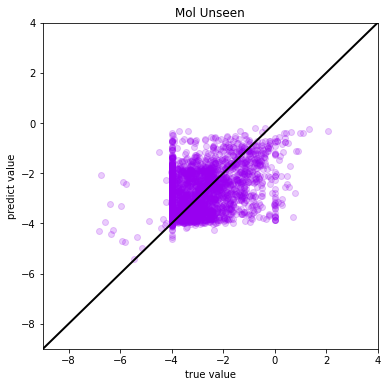

In [13]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

cmap = LinearSegmentedColormap.from_list("mycmap", ["#DEC0F0", "#9800F0"])
fig = plt.figure(figsize=(6, 6))
plt.xlabel("true value")
plt.ylabel("predict value")
plt.scatter(unseenmol_lab, unseenmol_pred, alpha = 0.2, color='#9800F0')
plt.plot(range(-9,5), range(-9,5),color="black",linewidth=2)
plt.xlim(-9,4)
plt.ylim(-9,4)
plt.title("Mol Unseen")
plt.savefig(plot_path + "unseenmol_confusion_mat.svg", dpi=200)

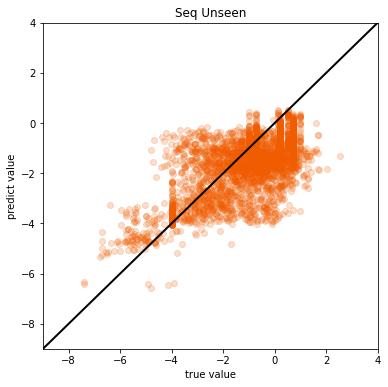

In [14]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F0DCD1", "#F05C00"])
fig = plt.figure(figsize=(6, 6))
plt.xlabel("true value")
plt.ylabel("predict value")
plt.scatter(unseenseq_lab, unseenseq_pred, alpha = 0.2, color='#F05C00')
plt.plot(range(-9,5), range(-9,5),color="black",linewidth=2)
plt.xlim(-9,4)
plt.ylim(-9,4)
plt.title("Seq Unseen")
plt.savefig(plot_path + "unseenseq_confusion_mat.svg", dpi=200)

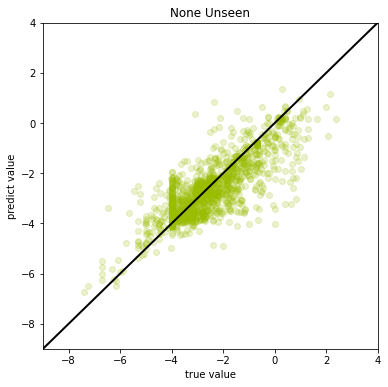

In [15]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F9FFDE", "#9ABD00"])
fig = plt.figure(figsize=(6, 6))
plt.xlabel("true value")
plt.ylabel("predict value")
plt.scatter(unseennone_lab, unseennone_pred, alpha = 0.2, color='#9ABD00')
plt.plot(range(-9,5), range(-9,5),color="black",linewidth=2)
plt.xlim(-9,4)
plt.ylim(-9,4)
plt.title("None Unseen")
plt.savefig(plot_path + "unseennone_confusion_mat.svg", dpi=200)

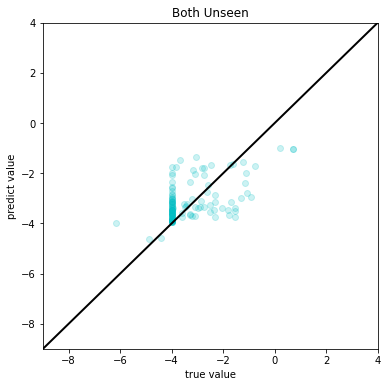

In [16]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["#B8FDFF", "#00BEC4"])
fig = plt.figure(figsize=(6, 6))
plt.xlabel("true value")
plt.ylabel("predict value")
plt.scatter(unseenboth_lab, unseenboth_pred, alpha = 0.2, color='#00BEC4')
plt.plot(range(-9,5), range(-9,5),color="black",linewidth=2)
plt.xlim(-9,4)
plt.ylim(-9,4)
plt.title("Both Unseen")
plt.savefig(plot_path + "unseenboth_confusion_mat.svg", dpi=200)